# CCD Calibration Lab Analysis #

This notebook describes how to do the analysis for the CCD lab using python.  On the class website, you can also find instructions for how to do this using pyraf.

## Data Collection


In the data collection part of the lab, you should obtain the following images:

* **Bias Frames** 
    - 2 bias frames.  A bias frame is an image taken with no light hitting the CCD and an exposure time of zero seconds.  
    - These frames show you the counts that you get just from the electronics.
    - Name these frames biasXX.fits, where XX is the sequence number (like bias01.fits, bias02.fits, etc)

* **Dark Frames - warm:**
    - a series of images with increasing exposure time, with no light hitting the detector and the temperature of the CCD set to room temperature (20 C)
    - Name these frames darkwarmXX.fits, where XX is the exposure time (like darkwarm01.fits, darkwarm05.fits, etc)

* ** Dark Frames - cold:**
    - a series of images with increasing exposure time, with no light hitting the detector and the temperature of the CCD set to -5 C 
    - Name these frames darkcoldXX.fits, where XX is the exposure time (like darkcold01.fits, darkcold05.fits, etc)

* At this point you should create a pinhole cover for the CCD and take the rest of the data through the pinhole aperture.  Make sure the camera is in the same orientation when taking the pinhole image and flat field exposures.

* ** Light Frames:**
    - a series of images of increasing exposure time to measure the linearity of your detector.  This will be used to characterize the linearity of your detector.
    - Name these frames lightXX.fits, where XX is the exposure time (like light01.fits, light05.fits, etc)

* ** Image Using a Pinhole Camera: **
    - Limit the light entering the CCD using a small pinhole entrance.
    - Take an three images in each of the B, V, and R filters. 

* ** Flat Field: **
    - This is a frames taken while the CCD is looking at an evenly illuminated screen.
    - Take five images in each filter that you used to create the pinhole camera image (e.g. B, V, and R).
    - Name these frames flatRXX.fits, where XX is the exposure number (like flatR01.fits, flatR02.fits, flatV01.fits, etc)


## Transferring the Data ##
When you have finished collecting your data, you need to move the data to a place where you can analyze the data using python (nanook or your own laptop).  You can move the data to a shared google drive folder, or use scp to copy the data to nanook or your laptop.  For example, you would type

    scp *.fits siena_username@nanook.physics.siena.edu:ccd_lab/.
    
   


## Setting up python

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import argparse
from astropy.io import fits
%matplotlib inline

## Read Noise

One of the easiest parameters to measure is the read noise of the CCD.  This is the noise the arises in the Analog-to-Digital converter from an imperfect conversion of electrons into a digital signal.

We will measure the read noise using the difference of two bias frames.  Because there is no light hitting the detector, there will be no Poisson noise.  Because the integration time of a bias frame is zero (or 0.12 seconds, in our case), there is no dark current in the image.  The only noise that will be in the difference image is the read noise.   

To begin, read in two bias frames:

In [7]:
bias1=fits.getdata('bias.fits')# you will need to put in the names of your files here
bias2=fits.getdata('bias2.fits')
diff_bias=bias2-bias1

Let's take a look at what the difference image looks like.

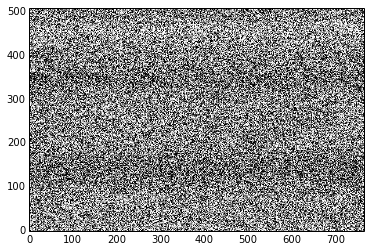

In [8]:
plt.imshow(diff_bias,vmin=-2,vmax=2,cmap='Greys')

In the image above, there appears to be some large-scale variations in counts along the columns.  So, we could measure the standard deviation over the entire image, or we could try to measure the noise in a smaller region, like 

    300 < x < 400
    200 < y < 275
    
To specify a subset of the image.  Turns out they give pretty similar results, so in this case, either way is ok.

In [31]:
readnoise=np.std(diff_bias)
# or of a subset of the image
readnoise_sub = np.std(diff_bias[300:400,200:275])
print 'STD over the entire array = %5.2f'%(readnoise)
print 'STD over a subset of the array = %5.2f'%(readnoise_sub)

STD over the entire array = 10.88
STD over a subset of the array = 10.76


This is our read noise in ADU.  Normally, read noise is quoted in units of electrons, so we have to multiply this number by the gain, where gain is measured in electrons per ADU.

$$ readnoise_{e-} = readnoise_{ADU} \times gain $$

The gain for your CCD is listed in the image header under EGAIN.  We can access the header information in a similar way that we get the data in the fits image.

In [15]:
bias1hdr=fits.getheader('bias.fits')
gain=bias1hdr['EGAIN']
readnoise_adu = readnoise*gain
print 'Gain = %5.2f e-/ADU'%(gain)
print 'Readnoise in ADU = %5.2f'%(readnoise_adu)

Gain =  2.30 e-/ADU
Readnoise in ADU = 25.02


## Dark Current

Let's say that you named all of your dark frames as ExpNolightXX.fits, where XX is replaced by the exposure time.  (You can change the file name in the code below if need be.)

You should open a few images in ds9 and select an area on the image that you want to use to measure the statistics.  Below, I use 

    300 < x < 500
    200 < y < 250
    
but this might not be a good region for you.  You can change the values as needed. 

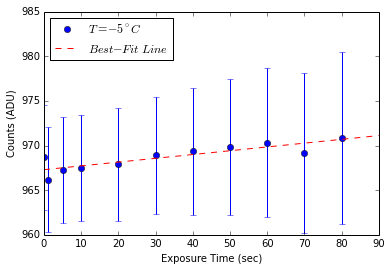

In [25]:
# get input files
infiles=glob.glob('ExpNolightCold*.fits')
# initialize arrays to store the mean, variance and standard deviation of each image
im_mean=np.zeros(len(infiles),'f')
im_var=np.zeros(len(infiles),'f')
im_std=np.zeros(len(infiles),'f')
im_expt=np.zeros(len(infiles),'f')
i=0
for ifile in infiles:
    #print ifile
    dat=fits.getdata(ifile)
    hdr=fits.getheader(ifile)
    im_expt[i]=hdr['EXPTIME']
    im_mean[i]=np.mean(dat[300:500,200:250])
    im_var[i] = np.var(dat[300:500,200:250])
    im_std[i] = np.std(dat[300:500,200:250])
    i += 1

plt.figure()
plt.plot(im_expt,im_mean,'bo',label='$T = -5^\circ C$')
plt.errorbar(im_expt,im_mean,im_std,fmt=None)
plt.xlabel('Exposure Time (sec)')
plt.ylabel('Counts (ADU)')
# fit a line to the data!
c1=np.polyfit(im_expt,im_mean,1) # this is the same function that we use in matlab 
time=np.linspace(0,90,100)
yfit=np.polyval(c1,time)
plt.plot(time,yfit,'r--',label='$Best-Fit \ Line$')
plt.legend(numpoints=1,loc='upper left')


In the manual, the dark current is quoted in units electrons/min, so we will convert our best-fit slope to these units.  The variable c1 now has the coefficients of the straight line that was fit to the data, and c1[0] is the slope of the fit.  The slope is in units of ADU/s, so we need to multiply by the $60 \times gain$ to convert to e-/min.

In [30]:
print 'Dark Current at -5 C = %5.1f e-/min'%(c1[0]*60*gain)

Dark Current at -5 C =   5.9 e-/min


You need to repeat this analysis for the second set of dark current data that was taken at room temperature.  Plot both data sets on the same graph, and report the dark current for each temperature.  Compare your values to the dark current that is quoted in the User's Manual for your CCD.

## Linearity

The analysis for linearity will be very similar to the analysis for measuring the dark current.  We want to plot counts versus time and determine where the data start to deviate from a straight line.  We should fit the line to the data with lower counts and then look for where the higher-count images start falling below the linear relation.

Can you do this one your own?  If not, I can help you with it.

## Flatfield Images

The flatfield image is an image taken when the CCD is evenly illuminated.  If the illumination is even across the CCD, then any variation in pixel values are a result of variations in pixel response.  Below, I read in a flat-field image and display it with the imshow command.

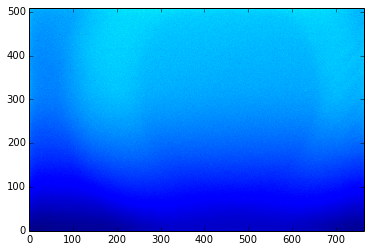

In [5]:
flat1='Flat_field_1.fits'
fdat1=fits.getdata(flat1)
plt.figure()
plt.imshow(fdat1)

Unfortunately, the illumination on this image does not look very uniform.  You can open your flatfield image in ds9 to get an idea of how much the counts vary across the image.  We are going to ignore the fact that the illumination is not even and plow ahead, pretending everything is just fine.

The goal of the flat is to correct for variations in pixel response; for every 100 photons that hit a pixel, some pixels will detect 95, and other pixels will detect 90.  The correct for this variation, you need to divide by the flatfield so that images with lower responses will have their pixels scaled by a greater value.  The flatfield must be normalized first, so that the average counts equal 1.

In [6]:
# normalize the flatfield image so that the average counts are 1
nfdat1=fdat1/np.mean(fdat1)

The flat is now ready to be used for calibrating your data.  You can divide your object frames by the normalized flat.  

You are asked to characterize the variation in quantum efficiency among the pixels in your CCD.  To do this, you can make a histogram of pixel values in the normalized flatfield image (these values are stored in nfdat1).

Ideally, you take an image of the twighlight sky while the CCD is on the telescope.  This is what you should do when you take images for your independent project.

## Bonus - Calculate the Gain!

In the slides on CCDs, I describe how to measure the gain of your CCD.  This is a complicated process, and so I have made this section extra credit for those of you looking for a challenge.  Follow the procedure outlined in the slides, and then compare your measured value to the gain that is listed in your image headers.  You can use either pyraf or python to accomplish this.